In [1]:
dgr1 = -30
dgr2 = 0
months = 'DJF' #'DJF' 'JJA'

In [2]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from numpy import *
import glob
#import xarray as xr
%matplotlib inline
#wd='/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/'
## nudged wd='/glade/campaign/uwyo/wyom0124/daily/PD/

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd

In [5]:
def get_regride(lats_out, lons_out):
    #  excludes LWP from heavy precipitating regions from observations (Elsaesser et al., 2017)
    ds_filter = np.load('/glade/derecho/scratch/cisong/backup_FOR_wyom0124/LWP_obs/filter/clwpfilter.npz') 
    ds = xr.DataArray(ds_filter['clwp'], dims=['lat','lon'], coords={'lat':ds_filter['lat'], 'lon':ds_filter['lon']})
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lats_out),
            "lon": (["lon"], lons_out),
        }
    )

    regridder = xe.Regridder(ds, ds_out, "bilinear")
    ds_out = regridder(ds)
    ds_out.data[ds_out.data>=0] = 1
    ds_out.data[ds_out.data<0] = np.nan
    return ds_out

In [6]:
import netCDF4 as nc
import xarray as xr
def get_xrData(ACTNL_a,dts,lats,lons):
    ACTNL_xa = xr.DataArray(ACTNL_a, dims=['time','lat','lon'], 
                            coords={'time':dts,'lat':lats,'lon':lons})
    lon_name = 'lon'  # whatever name is in the data

    # Adjust lon values to make sure they are within (-180, 180)
    out_var = ACTNL_xa
    out_var['_longitude_adjusted'] = xr.where(
        out_var[lon_name] > 180,
        out_var[lon_name] - 360,
        out_var[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    out_var = (
        out_var
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(out_var._longitude_adjusted)})
        .drop(lon_name))

    out_var = out_var.rename({'_longitude_adjusted': lon_name})
    out_var = out_var.rename({'lon': 'longitude','lat': 'latitude'})
    return out_var
def get_wtdata2(data1, area):
    data1 = data1.sel(latitude=area)
    weights = np.cos(np.deg2rad(data1.latitude))
    weights.name = "weights"
    data1_wgted = data1.weighted(weights)
    data1_m = data1_wgted.mean(dim=['time','latitude','longitude'])
    return data1_m

path = '/glade/derecho/scratch/cisong/backup_FOR_wyom0124/CERES/'
file ='CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc'
ds =  nc.Dataset(path+file, 'r')
dgr = 50
toa_sw_all_mon   = ds.variables['toa_sw_all_mon'][:]
toa_sw_clr_c_mon = ds.variables['toa_sw_clr_c_mon'][:]
solar_mon        = ds.variables['solar_mon'][:]
SW_down          = solar_mon
albedo           = toa_sw_all_mon/SW_down
albedo_cs        = toa_sw_clr_c_mon/SW_down
tt               = ds.variables['time']
from cftime import num2date, date2num
tt               = num2date(tt,units=tt.units)
lon              = ds.variables['lon'][:]
lat              = ds.variables['lat'][:]
albedo           = get_xrData(albedo,tt,lat,lon).sel(time=slice('2000','2016'))
albedo_cs        = get_xrData(albedo_cs,tt,lat,lon).sel(time=slice('2000','2016'))
albedo_JJA       = albedo.groupby('time.season')[months].sel(latitude=slice(dgr,80))
albedo_cs_JJA    = albedo_cs.groupby('time.season')[months].sel(latitude=slice(dgr,80))

flag = 0
for time in range(2000,2017):
    #print(time)
    path = '/glade/derecho/scratch/cisong/backup_FOR_wyom0124/LWP_obs/'
    file ='maclwp_cloudlwpave_'+str(time)+'_v1.nc4'
    ds =  xr.open_dataset(path+file,decode_times=False)
    clwp = ds.cloudlwp
    dts = pd.date_range(str(time)+"-01-01",str(time)+"-12-31",freq='MS')
    clwp=clwp.assign_coords({'time': dts}) 
    lats = clwp.lat
    lons = clwp.lon
    clwp = get_xrData(clwp,dts,lats,lons)
    if flag == 0:
        clwp_a = clwp
        flag = 1
    else:
        clwp_a = xr.concat((clwp_a, clwp), dim='time')
clwp_a = clwp_a.sel(time=slice('2000', '2016'))

def plot_albedo_ceres(albedo,albedo_cs,LWP):
    maxcs=0.12
    zz=albedo; yy=albedo_cs;
    xx=LWP;
    zz=np.ravel(albedo); yy=np.ravel(albedo_cs);
    xx=np.ravel(LWP);    
    print(np.nanmean(zz),np.nanmean(yy),np.nanmean(xx))
    ind=(yy<maxcs)&(np.isnan(xx*zz)==False)&(xx>np.nanpercentile(xx,5))&(xx<np.nanpercentile(xx,95))
    from scipy.stats import binned_statistic, linregress
    #plt.scatter(xx[ind],zz[ind],20,yy[ind])
    print(ind.shape)
    bb=np.linspace(np.nanpercentile(xx[ind],5),np.nanpercentile(xx[ind],95),15)
    xxx=binned_statistic(xx[ind],xx[ind],bins=bb)
    yyy=binned_statistic(xx[ind],zz[ind],bins=bb)
    cc=binned_statistic(xx[ind],zz[ind],bins=bb,statistic='count')[0]
    print(np.nanmean(xxx[0]),np.nanmean(yyy[0]))
    #fig      = plt.figure(figsize=(6,5))
    #ax       = fig.add_subplot(111)
    plt.plot(xxx[0],yyy[0],'k',lw=2)
    plt.plot(xxx[0],yyy[0],'x', c='r')
    #plot(mean(xx[ind]),mean(zz[ind]),'xk')
    dadl=np.gradient(yyy[0])/np.gradient(xxx[0])
    from scipy.interpolate import interp1d
    intp=interp1d(xxx[0],dadl)
    #print(mean(xx[ind]))
    ind2=(yy<maxcs)&(np.isnan(xx*zz)==False)
    return fig,ax,linregress(xx[ind],zz[ind]),intp(np.nanmean(xx[ind2])),sum(dadl*cc)/sum(cc)

In [28]:
# Geethma added this
def get_regride(lats_out, lons_out):
    import numpy as np
    import xarray as xr

    ds_filter = np.load(
        '/glade/derecho/scratch/cisong/backup_FOR_wyom0124/LWP_obs/filter/clwpfilter.npz'
    )

    # source mask
    da_src = xr.DataArray(
        ds_filter['clwp'],
        dims=['lat', 'lon'],
        coords={
            'lat': ds_filter['lat'],
            'lon': ds_filter['lon']
        }
    )

    # interpolate mask to target grid
    da_out = da_src.interp(
        lat=lats_out,
        lon=lons_out,
        method='linear'
    )

    # convert to binary mask
    da_out = xr.where(da_out >= 0, 1, np.nan)

    return da_out

# --- CLWP ---
mask = get_regride(clwp_a.latitude, clwp_a.longitude)
clwp_mask = clwp_a * mask

clwp_mask_JJA = (
    clwp_mask
    .where(clwp_mask['time.season'] == months, drop=True)
    .sel(latitude=slice(dgr1, dgr2))
)

# --- Albedo ---
mask = get_regride(albedo.latitude, albedo.longitude)

albedo_mask = albedo * mask
albedo_cs_mask = albedo_cs * mask

albedo_mask_JJA = (
    albedo_mask
    .where(albedo_mask['time.season'] == months, drop=True)
    .sel(latitude=slice(dgr1, dgr2))
)

albedo_cs_mask_JJA = (
    albedo_cs_mask
    .where(albedo_cs_mask['time.season'] == months, drop=True)
    .sel(latitude=slice(dgr1, dgr2))
)

# --- ADD YEAR + MONTH COORDINATES ---
def add_year_month(da):
    return da.assign_coords(
        year=da['time.year'],
        month=da['time.month']
    )

clwp_mask_JJA      = add_year_month(clwp_mask_JJA)
albedo_mask_JJA    = add_year_month(albedo_mask_JJA)
albedo_cs_mask_JJA = add_year_month(albedo_cs_mask_JJA)

# --- ALIGN BY YEAR + MONTH ---
clwp_mask_JJA, albedo_mask_JJA, albedo_cs_mask_JJA = xr.align(
    clwp_mask_JJA,
    albedo_mask_JJA,
    albedo_cs_mask_JJA,
    join='outer',
    exclude=['time']
)

# --- TAKE ONLY COMMON YEAR + MONTH VALUES ---
def year_month_pairs(da):
    return set(zip(da.year.values, da.month.values))

common_ym = (
    year_month_pairs(clwp_mask_JJA) &
    year_month_pairs(albedo_mask_JJA) &
    year_month_pairs(albedo_cs_mask_JJA)
)

def subset_common_year_month(da, common_ym):
    ym = np.array(list(zip(da.year.values, da.month.values)))
    mask = np.array([(y, m) in common_ym for y, m in ym])
    return da.isel(time=mask)

clwp_mask_JJA      = subset_common_year_month(clwp_mask_JJA, common_ym)
albedo_mask_JJA    = subset_common_year_month(albedo_mask_JJA, common_ym)
albedo_cs_mask_JJA = subset_common_year_month(albedo_cs_mask_JJA, common_ym)

# --- OPTIONAL: set (year, month) as new index ---
def set_year_month_index(da):
    return da.set_index(time=['year','month']).rename({'time':'year_month'})

clwp_mask_JJA      = set_year_month_index(clwp_mask_JJA)
albedo_mask_JJA    = set_year_month_index(albedo_mask_JJA)
albedo_cs_mask_JJA = set_year_month_index(albedo_cs_mask_JJA)

# --- SANITY CHECK ---
print("Lengths of time axes:", len(clwp_mask_JJA.year_month),
      len(albedo_mask_JJA.year_month),
      len(albedo_cs_mask_JJA.year_month))

print("First 5 year_month values:", clwp_mask_JJA.year_month.values[:5])



Lengths of time axes: 49 49 49
First 5 year_month values: [(2000, 12) (2001, 1) (2001, 2) (2001, 12) (2002, 1)]


In [8]:
# print(type(clwp_mask_JJA.time.values[0]))
# print(type(albedo_mask_JJA.time.values[0]))
# print(type(albedo_cs_mask_JJA.time.values[0]))


In [29]:
# albedo_mask_JJA

In [31]:
# clwp_mask_JJA

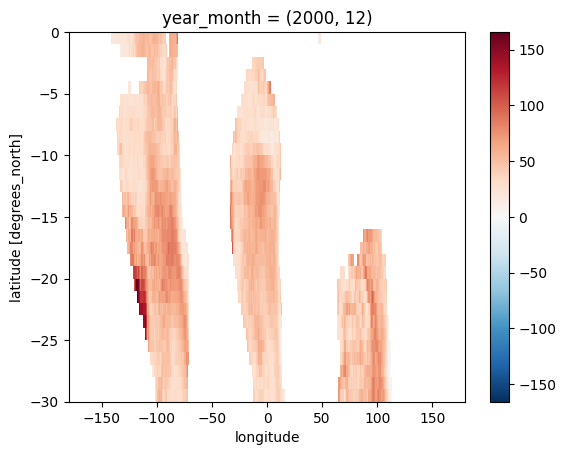

In [32]:
clwp_mask_JJA[0].plot()

In [33]:
def get_data(fnum,varnm='FSDS',runval='PPE_rerun_ensemble_PD',type_run='PD'):
    fnums=str(fnum)
    if fnum<100:
        fnums='0'+fnums
        if fnum<10:
            fnums='0'+fnums
    WD='/glade/campaign/cgd/projects/ppe/cam6_nudged_ppe/daily/'+type_run+'/'+runval+'.'#001/atm/hist/PPE_rerun_ensemble_PD.001.cam.h0.2016-01.nc'
    fn=WD+fnums+'/atm/hist/'+runval+'.'+fnums+'.cam.h0.*.nc'
    #WD='/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/'+runval+'/'+runval+'_timeseries/'
    #fn=WD+'PPE_250_ensemble_'+runval+'.'+fnums+'/atm/hist/cc_PPE_250_ensemble_'+runval+'.'+fnums+'.h0.'+varnm+'.nc'
    #if fnum==175:
    #    fn='/glade/campaign/cgd/projects/ppe/cam_ppe/PPE_250/control/control_timeseries/PPE_250_ensemble.175/atm/hist/cc_PPE_250_ensemble.'+fnums+'.h0.'+varnm+'.nc'
    import netCDF4 as nc
    from datetime import datetime
    #print(fnum)
    f = nc.MFDataset(fn, 'r')
    tvar = 'time'
    tt = f.variables[tvar]
    latvar = 'lat'
    lonvar = 'lon'
    lat = f.variables[latvar][:]
    lon = f.variables[lonvar][:]
    Z = f.variables[varnm][:]
    lon[lon > 180] = lon[lon > 180]-360
    ind = argsort(lon)
    lon = lon[ind]
    Z = 1.*Z[:,:,ind]
    ind2 = argsort(lat)
    Z = 1.*Z[:,ind2,:]
    lat = lat[ind2]
    #import numpy.ma
    #Z=1.*Z.filled(fill_value=NaN)
    return [Z, lat, lon,tt]
    

In [34]:
def albedo_get(data):
    SW_down=data['FSNTOA'][0]+data['FSUTOA'][0]
    albedo=data['FSUTOA'][0]/SW_down
    albedo_cs=-(data['FSNTOAC'][0]-SW_down)/SW_down
    SWCRE=data['FSUTOA'][0]+(data['FSNTOAC'][0]-SW_down)
    #Nd=data[i]['ACTNL'][0]/data[i]['FCTL'][0]
    return albedo,albedo_cs,1.*SWCRE#,Nd
    

In [35]:
def plot_albedo(data, fig,ax):
    ## this subroutine reads in albedo, clear sky albedo, and LWP.
    ## a few different methods are used to get dalbedo/dLWP. 
    ## clear sky albedo is used to filter out land and other situations where it would 
    ## be hard to get a sensitivity.
    ## Latitudes between 30-70N are used. 
    ## time range is set to JJA.
    maxcs=0.12  ### maximum clear sky albedo
    from cftime import num2date, date2num
    tt=num2date(data['albedo'][3][:],units=data['albedo'][3].units,calendar=data['albedo'][3].calendar)
    tt = pd.date_range("2016-01-01","2018-01-01",freq='MS')
    #print(tt)
    mm=zeros(len(tt))
    for j in range(len(mm)):
        mm[j]=tt[j].month
        
    lat=data['albedo'][1]
    
    lon_grid, lat_grid = np.meshgrid(data['albedo'][2],data['albedo'][1])
    ocean          = globe.is_land(lat_grid, lon_grid)==False
    #print(ocean.shape)
    ocean          = np.tile(ocean, (1,1))
    ocean          = ocean*1
    ocean          = ocean.astype('float')
    ocean[ocean==0]=np.nan

    latind=(lat>dgr1)&(lat<dgr2) ## restrict latitude
    tind=(mm<9)&(mm>5) ### restrict month of the year tind=(mm<9)&(mm>5)
    #tind=(mm==1)|(mm==2)|(mm==12)
    #print(tind)
    zz=data['albedo'][0]; yy=data['albedo_cs'][0];
    xx=data['TGCLDLWP'][0];
    mask = get_regride(data['albedo'][1], data['albedo'][2])
    xx = xx.data*mask.data
    #xx = albedo.copy(data=lwp)
    #print(np.shape(xx))
    #plt.pcolormesh(np.nanmean(xx, axis=0))
    xx = xx*ocean # remove land data
    #print(xx.shape)
    zz=zz[tind]*1.; yy=yy[tind]*1.; xx=xx[tind]*1.
    zz=zz[:,latind,:]*1.; yy=yy[:,latind,:]*1.; xx=xx[:,latind,:]*1.
    #print(xx.shape)
    ind=(yy<maxcs)&(isnan(xx*zz)==False)&(xx>nanpercentile(xx,5))&(xx<nanpercentile(xx,95))
    ## select for clear sky less than the max and LWP in the 90% (in case of big outliers)
    from scipy.stats import binned_statistic, linregress
    #scatter(xx[ind],zz[ind],20,yy[ind])
    #print(xx[ind].shape)
    bb=linspace(nanpercentile(xx[ind],5),nanpercentile(xx[ind],95),15)
    xxx=binned_statistic(xx[ind],xx[ind],bins=bb)
    yyy=binned_statistic(xx[ind],zz[ind],bins=bb)
    cc=binned_statistic(xx[ind],zz[ind],bins=bb,statistic='count')[0]
    plt.plot(xxx[0],yyy[0],color='grey')
    #print(xxx[0].shape)
    #plt.plot(mean(xx[ind]),mean(zz[ind]),'x')
    dadl=gradient(yyy[0])/gradient(xxx[0]) ### calculate the gradient in albedo wrt to LWP
    from scipy.interpolate import interp1d
    intp=interp1d(xxx[0],dadl) 
    #print(mean(xx[ind]))
    ind2=(yy<maxcs)&(isnan(xx*zz)==False)
    return linregress(xx[ind],zz[ind]),intp(nanmean(xx[ind2])),sum(dadl*cc)/sum(cc), [xxx[0],yyy[0]] 
    ### return linear regression, mean LWP, mean gradient, raw LWP and albedo data for 90% range and lower clear-sky albedo

In [36]:
def gm(data,lat,lr=[-90,90]):
    data=nanmean(data,axis=(0,2))
    lw=cos(pi*lat/180)
    ind=(lat<max(lr))&(lat>min(lr))
    return sum(data[ind]*lw[ind])/sum(lw[ind])

In [37]:
def get_data_ens_mem(ensn, fig, ax):
    from cftime import num2date, date2num
    varnms=['FSUTOA','FSNTOAC','FSNTOA','TGCLDLWP']#,'ACTNL','FCTL']
    i = ensn
    data={}
    datapi={}
    for j in range(len(varnms)):
        try:
            data[varnms[j]]=get_data(i,varnm=varnms[j],runval='PPE_rerun_ensemble_PD',type_run='PD')
        except OSError:
            print('FileNotFoundError')
    #print(data['FSUTOA'][3][:])
    albedo=albedo_get(data)
    data['albedo']=[albedo[0],data['FSNTOA'][1],data['FSNTOA'][2],data['FSNTOA'][3]]
    data['albedo_cs']=[albedo[1],data['FSNTOA'][1],data['FSNTOA'][2],data['FSNTOA'][3]]
    data['SWCRE']=[albedo[2],data['FSNTOA'][1],data['FSNTOA'][2],data['FSNTOA'][3]]
    lm=plot_albedo(data, fig, ax)
    mm=lm[1]
    mm2=lm[0][0]; 
    mm2se=lm[0][4]; 
    mm3=lm[2]
    mm_ar = lm[-1]
    return {'grd':mm,'per1090reg':mm2,'per1090reg_se':mm2se,'wght_mn_grd':mm3,'mm_ar':mm_ar}

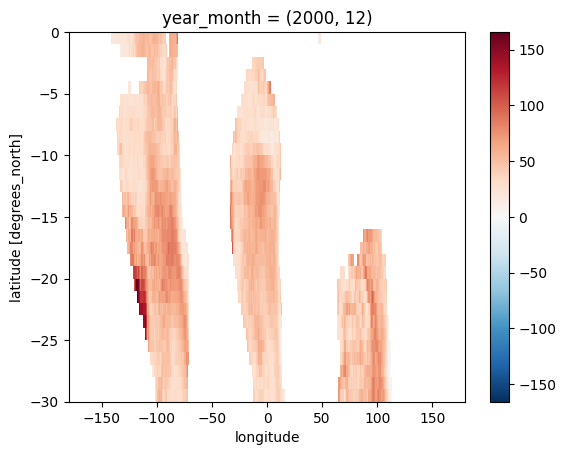

In [38]:
clwp_mask_JJA[0].plot()

0
0.18908172163210357 0.09757059385673486 0.04947048093933856
(529200,)
0.05087412343969663 0.19147389370285844


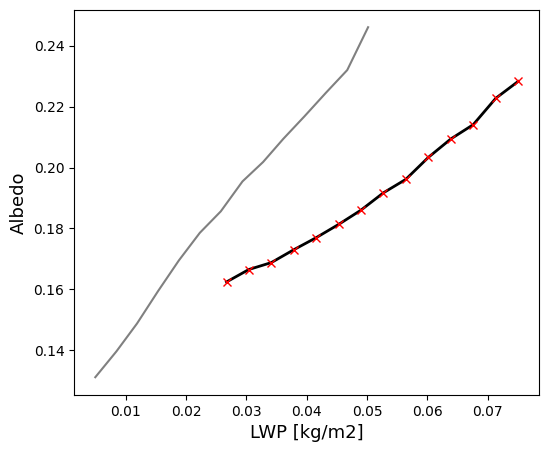

In [39]:
svdir='/glade/campaign/uwyo/wyom0178/dadlwp_Ci/'
from global_land_mask import globe
#fig.savefig('/glade/work/cisong/figures_PPE/obs_dadlwp.png', dpi=500)
fig      = plt.figure(figsize=(6,5))
ax       = fig.add_subplot(111)

for i in range(0,1):
    print(i)
    try:
        ensn=i
        mm=get_data_ens_mem(ensn, fig, ax)
        ensn_p=str(ensn)
        if ensn<100:
            ensn_p='0'+ensn_p
            if ensn<10:
                ensn_p='0'+ensn_p
        savez(svdir+f'reg_{dgr1}_{dgr2}_{months}_mem_{ensn_p}.npz',m1090=mm['per1090reg'],
              m_se1090=mm['per1090reg_se'],m_grd=mm['grd'],m_wght_mn_grd=mm['wght_mn_grd'],mm_ar=mm['mm_ar'],ensn=ensn)
    except KeyError:
        print('KeyError')
results = plot_albedo_ceres(albedo_mask_JJA,albedo_cs_mask_JJA,clwp_mask_JJA/1000.) # Obs da/dlwp is results[-1]
fig = results[0]
ax  = results[1]
ax.set_xlabel('LWP [kg/m2]', fontsize=13)
ax.set_ylabel('Albedo', fontsize=13)

np.save(f'{svdir}reg_{dgr1}_{dgr2}_{months}_da_dlwp_obs.npy', results[-1])


In [22]:
clwp_mask_JJA

<xarray.DataArray (time: 51, latitude: 30, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2016-12-01
  * latitude   (latitude) float32 -29.5 -28.5 -27.5 -26.5 ... -2.5 -1.5 -0.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    lat        (latitude) float32 -29.5 -28.5 -27.5 -26.5 ... -2.5 -1.5 -0.5
    lon        (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    year       (time) int64 2000 2000 2000 2001 2001 ... 2015 2016 2016 2016
    month      (time) int64 1 2 12 1 2 12 1 2 12 1 2 ... 12 1 2 12 1 2 12 1 2 12